# Basic Particle Tracking Plots

The code in this notebook showcases the basic syntax for reading in and analyzing particle tracking data. Specifically, this notebook is where I generate the pathline plots that are currently in my paper draft as Figure 1. Also, I do some testing of the fractions plots in this notebook as well, though I actually generate the final figure in `./scripts/census_plots.py`. 

`-- Hollis Akins, May 18 2021 --`


## Table of Contents

- [Generate Table of Data](#table)
- [Basic Overview ](#overview)
- [Basic pathlines](#basic-pathlines)
- [Advanced pathlines](#advanced-pathlines)
- [Fractions plots](#fractions)
- [Tracking stars](#stars)
- [Fractions plots (with stars)](#fractions-stars)

In [1]:
# import my custom module which includes my analysis functions (also imports everything from base.py)
from analysis import * 

# Generate Table of Data <a class="anchor" id="table"></a>

In my current paper draft I include a table showing  basic properties of all 19 satellites in the sample. Because I am lazy, I have written some python code here to compile this table for me and print it out in a $\LaTeX$ table format. 

In [6]:
# sims = ['h148','h229','h242','h329']
# simnames = ['Sandra','Ruth','Sonia','Elena']
# haloids = {'h148':[12,27,34,38,55,65,249,251,282],
#            'h229':[14,18,20,22,49],
#            'h242':[21,38,69],
#            'h329':[29,117]}

sims = ['h148','h229','h242','h329']
simnames = ['Sandra','Ruth','Sonia','Elena']
haloids = {'h148':[2,3,4,6,7,10,12,23,27,34,38,55,65,249,251,282],
           'h229':[14,18,20,22,49],
           'h242':[8,10,21,30,38,69,401],
           'h329':[7,29,117]}


timescales = read_timescales() # (function defined in base.py)
ip = read_infall_properties() # (function defined in base.py)

i = 1
for sim,simname in zip(sims,simnames):
    timesteps = read_timesteps(sim)
    for haloid in haloids[sim]:
        i += 1
        ts = timescales[(timescales.sim==sim)&(timescales.haloid==haloid)]
        mstar_z0 = ts.M_star.tolist()[0]
        exp = int(np.floor(np.log10(mstar_z0)))
        mstar_z0 /= 10**(exp)
        mstar_z0 = fr'{mstar_z0:.1f} \times 10^{exp}'
        
        mgas_ti = ip[(ip.sim==sim)&(ip.haloid==haloid)].M_gas_at_infall.tolist()[0]
        exp = int(np.floor(np.log10(mgas_ti)))
        mgas_ti /= 10**(exp)
        mgas_ti = fr'{mgas_ti:.1f} \times 10^{exp}'
        
        tau = ts.tinfall.tolist()[0] - ts.tquench.tolist()[0]
        
        quenched = bool(ts.quenched.tolist()[0])
        if quenched:
            if tau < 3: 
                speed = f'{tau:.1f}'
            elif tau >= 3:
                speed = f'{tau:.1f}^*'
        else:
            speed = r'\mathrm{N/A}'
            
        ts = timesteps[timesteps.haloid==haloid]
        r_peri = np.min(ts.h1dist)
        
        print(fr'{simname} & {haloid} & {mstar_z0} & {mgas_ti} & {r_peri:.2f} & {speed} \\')
        simname = '~'
    print(r'\hline')
i

Sandra & 2 & 2.3 \times 10^9 & 9.3 \times 10^9 & 0.72 & \mathrm{N/A} \\
~ & 3 & 1.5 \times 10^9 & 4.2 \times 10^9 & 0.90 & \mathrm{N/A} \\
~ & 4 & 4.3 \times 10^8 & 1.2 \times 10^9 & 0.75 & \mathrm{N/A} \\
~ & 6 & 3.3 \times 10^8 & 1.3 \times 10^9 & 0.81 & \mathrm{N/A} \\
~ & 7 & 2.4 \times 10^8 & 4.2 \times 10^8 & 1.23 & \mathrm{N/A} \\
~ & 10 & 1.4 \times 10^8 & 1.6 \times 10^9 & 0.48 & \mathrm{N/A} \\
~ & 12 & 1.0 \times 10^8 & 1.2 \times 10^8 & 0.76 & 0.9 \\
~ & 23 & 1.0 \times 10^8 & 1.4 \times 10^9 & 0.59 & \mathrm{N/A} \\
~ & 27 & 8.4 \times 10^7 & 9.8 \times 10^8 & 0.50 & 5.7^* \\
~ & 34 & 5.8 \times 10^6 & 2.0 \times 10^8 & 0.29 & 4.3^* \\
~ & 38 & 1.4 \times 10^7 & 1.4 \times 10^8 & 0.49 & 1.7 \\
~ & 55 & 2.8 \times 10^6 & 2.2 \times 10^8 & 0.30 & 3.5^* \\
~ & 65 & 3.0 \times 10^7 & 3.6 \times 10^7 & 0.44 & -0.6 \\
~ & 249 & 2.1 \times 10^6 & 1.2 \times 10^8 & 0.69 & 1.7 \\
~ & 251 & 2.1 \times 10^6 & 1.1 \times 10^8 & 1.11 & 0.4 \\
~ & 282 & 4.0 \times 10^6 & 6.9 \times 10^7

32

In [2]:
import socket
if socket.gethostname() == "quirm.math.grinnell.edu":
    z0data_prefix = '/home/akinshol/Research/Justice_League_Code/Data/z0_data/'
else:
    z0data_prefix = '/Users/hollis/My Drive/Grinnell/Research/Justice_League_Code/Data/z0_data/' # filepath is different on my local machine


def read_file(simname):
    '''
    A function that returns the compiled .data file for the given simname (one of 'h148', 'h229', 'h242', or 'h329'). 
    '''
    data = []
    with open(z0data_prefix + simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

        data1 = pd.DataFrame(data)
        data1['sim'] = [simname]*len(data1)
        data1['g-r'] = 1.646*(data1['V_mag'] - data1['R_mag']) - 0.139
        return data1
    
def read_sat():
    '''Function that returns a combined pandas dataframe for all Justice League simulations.'''
    data = read_file('h148')
    data = data.append(read_file('h229'))
    data = data.append(read_file('h242'))
    data = data.append(read_file('h329'))
    return data



In [4]:
data = read_sat()

#data['key'] = data['sim'] + '-' + data['haloid'].astype(str)

#old_keys = ['h148-13','h148-28','h148-37','h148-45','h148-45','h148-68','h148-80','h148-283','h148-278','h148-329',
#             'h229-20','h229-22','h229-23','h229-27','h229-55','h242-24','h242-41','h242-80','h329-33','h329-137']

#data = data[np.isin(data.key, old_keys)]
data['X'] = data['Xc'] * 0.67
data['Y'] = data['Yc'] * 0.67
data['Z'] = data['Zc'] * 0.67
data = data[['sim','haloid','M_star','M_gas','n_star','n_gas','mass','X','Y','Z']]

data.to_csv('old_z0_data_for_matching.csv', index=False)
# M_star = np.sum(halo.star['mass'])
# mass = np.sum(halo['mass'])
# X = halo.properties['X']



In [5]:
pd.read_csv('old_z0_data_for_matching.csv')

sim  haloid        M_star         M_gas    n_star    n_gas  \
0    h148       1  1.934697e+11  2.022541e+11  37915400  8170111   
1    h148       2  2.268773e+09  8.252345e+09    435389   352287   
2    h148       3  1.505383e+09  2.987673e+09    295443   130724   
3    h148       5  4.317847e+08  9.844133e+08     85749    41513   
4    h148       6  3.315968e+08  1.014057e+09     65528    41777   
..    ...     ...           ...           ...       ...      ...   
123  h329     185  4.424606e+04  0.000000e+00         9        0   
124  h329     447  6.107063e+05  0.000000e+00       124        0   
125  h329     729  4.912065e+03  0.000000e+00         1        0   
126  h329     996  7.860942e+04  0.000000e+00        16        0   
127  h329    1509  4.914921e+04  0.000000e+00        10        0   

             mass             X             Y             Z  
0    2.662469e+12  16928.941228  16724.133640  16473.164791  
1    9.575883e+10  16926.845047  16809.613684  16378.597862  
2    5.060912e+10  17067.761949  16617.641482  16435.745243  
3    3.353961e+10  17022.668949  16846.536936  16415.310628  
4    3.172889e+10  17129.337770  16762.462333  16550.625676  
..            ...           ...           ...           ...  
123  1.974277e+08  17978.377597  13783.737844  17803.662923  
124  6.427186e+07  17877.192047  13808.018575  17725.752669  
125  3.954943e+07  17991.273233  13751.279975  17774.604942  
126  2.737407e+07  18024.118723  13799.690714  17739.715997  
127  1.746908e+07  17987.799407  13720.464436  17772.662203  

[128 rows x 10 columns]

## Basic overview of particle tracking data <a class="anchor" id="overview"></a>

### Reading in the data

Particle tracking data is stored at `Justice_League_Code/Data/tracked_particles.hdf5`. This HDF5 file format stores multiple tables efficiently and can be easily written to/read into `pandas`. Each galaxy that has been tracked is stored as a table in the HDF5 file under the key `{sim}_{z0haloid}`. For example:

In [3]:
path = '/data/Justice League/tracked_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = [k[1:] for k in hdf.keys()]
    print('Available keys:', *keys)

Available keys: h148_10 h148_12 h148_2 h148_23 h148_249 h148_251 h148_27 h148_282 h148_34 h148_38 h148_4 h148_55 h148_6 h148_65 h148_7 h229_14 h229_18 h229_20 h229_22 h229_49 h242_10 h242_21 h242_30 h242_38 h242_401 h242_69 h242_8 h329_117 h329_29 h329_7


In [4]:
keys

['h148_10',
 'h148_12',
 'h148_2',
 'h148_23',
 'h148_249',
 'h148_251',
 'h148_27',
 'h148_282',
 'h148_34',
 'h148_38',
 'h148_4',
 'h148_55',
 'h148_6',
 'h148_65',
 'h148_7',
 'h229_14',
 'h229_18',
 'h229_20',
 'h229_22',
 'h229_49',
 'h242_10',
 'h242_21',
 'h242_30',
 'h242_38',
 'h242_401',
 'h242_69',
 'h242_8',
 'h329_117',
 'h329_29',
 'h329_7']

In [5]:
key = 'h242_21'
data = pd.read_hdf(path, key=key)
len(np.unique(data.pid))

9556

While it is certainly possible to import the data using `pd.read_hdf()`, I have also written a convenience function called `read_tracked_particles()` (defined in `bulk.py`) that imports the data and also does some calculations, like defining the different gas particle states.

(Notice the 9 additional columns in the dataset below vs. the dataset above)

In [6]:
sim, haloid = str(key[:4]), int(key[5:])
data = read_tracked_particles(sim, haloid)
data.head()

time      pid       rho           temp          mass  coolontime  \
0  5.504425   811077  0.000028  432336.593750  26510.536704    0.000000   
1  5.504425  6872943  0.000196  319767.500000  33820.756354    4.999814   
2  5.504425  8840402  0.000117   49517.355469  26510.536704    0.000000   
3  5.504425  8987571  0.000066  504670.218750  26510.536704    0.000000   
4  5.504425  9655109  0.000090  108882.289062  26510.536704    0.000000   

            r  r_per_Rvir           x           y  ...  in_IGM        dt  \
0  305.022240   12.623157 -161.623345   47.330543  ...    True  0.323235   
1  320.146521   13.249066 -142.218365  185.416891  ...   False  0.323235   
2  354.082766   14.653497  117.558627  221.454013  ...    True  0.323235   
3   23.280111    0.963433  -11.525379   -2.191478  ...    True  0.323235   
4   15.340095    0.634840   -5.805976  -13.678675  ...    True  0.323235   

      r_gal  host_r_gal  sat_disk  sat_halo  host_disk  host_halo  other_sat  \
0  0.557926   10.941918     False     False      False      False      False   
1  0.557926   10.941918     False     False      False       True      False   
2  0.557926   10.941918     False     False      False      False      False   
3  0.557926   10.941918     False     False      False      False      False   
4  0.557926   10.941918     False     False      False      False      False   

     IGM  
0   True  
1  False  
2   True  
3   True  
4   True  

[5 rows x 60 columns]

## Basic plots of satellite orbit and particle paths <a class="anchor" id="basic-pathlines"></a>

Here, we plot the satellite orbit in $x-y$ and in $x-z$, and plot the paths of a random sample of $N$ tracked particles. 

/var/folders/dh/0hn7jk0x3fn_xrckft0fhh2c0000gn/T/ipykernel_1222/3233710502.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('Reds', 12)


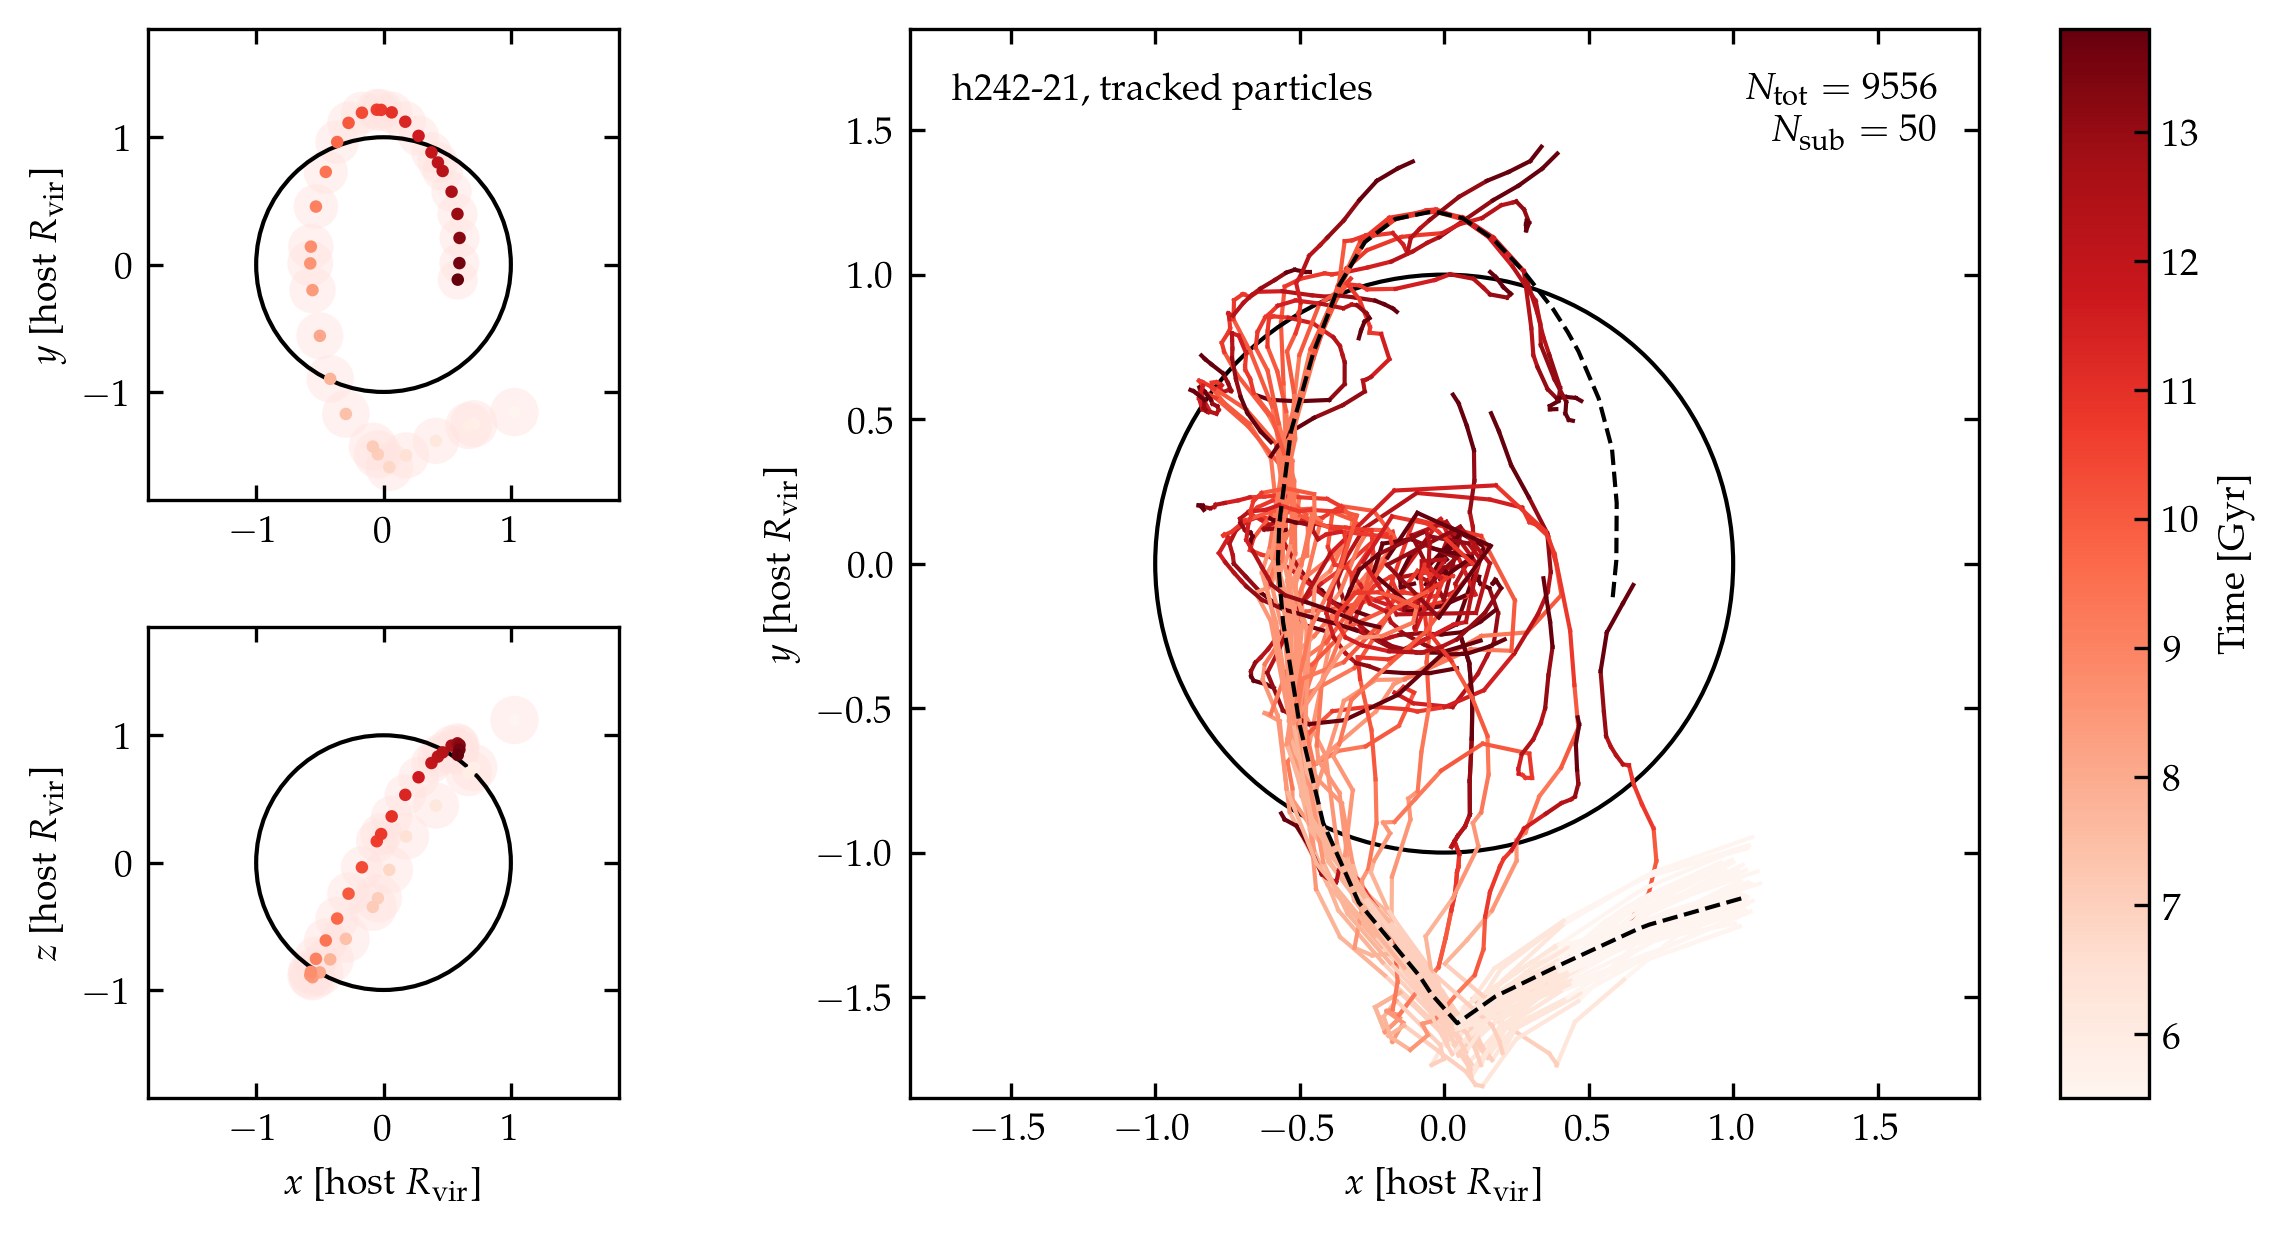

In [10]:
R = 1.85 # in Rvir, the maximum radius to plot 
N = 50 # number of particles to select in subsample

fig = plt.figure(dpi=300, figsize=(7.5,4))
gs = mpl.gridspec.GridSpec(2,5, width_ratios = [1,0.1,1,1,0.15], figure=fig)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0:,2:-1])
cbax = plt.subplot(gs[:,-1])

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax0.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax1.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax2.add_artist(host_radius)

x_rel, y_rel, z_rel, Rvirs, ts = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
for t in np.unique(data.time):
    d = data[data.time==t]
    sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
    host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)
    
    h1Rvir = np.mean(d.hostRvir)
    satRvir = np.mean(d.satRvir)
    
    x_rel = np.append(x_rel, (sat_x-host_x)/h1Rvir)
    y_rel = np.append(y_rel, (sat_y-host_y)/h1Rvir)
    z_rel = np.append(z_rel, (sat_z-host_z)/h1Rvir)
    
    Rvirs = np.append(Rvirs, satRvir/h1Rvir*1100)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_y-host_y)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax0.add_artist(radii)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_z-host_z)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax1.add_artist(radii)
    
    ts = np.append(ts,t)
    
ax0.scatter(x_rel, y_rel, c=ts, cmap='Reds', s=4, zorder=2)
ax1.scatter(x_rel, z_rel, c=ts, cmap='Reds', s=4, zorder=2)
# ax2.plot(x_rel, z_rel, 'k--', linewidth=1, zorder=1)
# ax2.plot(x_rel, z_rel, 'k--', linewidth=1, zorder=1)
ax2.plot(x_rel, y_rel, 'k--', linewidth=1, zorder=1000)

pids = np.unique(data.pid)
np.random.seed(123)
pids_sub = np.random.choice(pids, size=N)

for j,pid in enumerate(pids_sub):
    d = data[data.pid==pid]
    
    cmap = mpl.cm.get_cmap('Reds', 12)
    tmin, tmax = np.min(d.time), np.max(d.time)
    
    i_prev = 0
    for i in range(len(d)-1):
        i += 1
        h1Rvir = list(d.hostRvir)[i_prev]
        x1 = list(d.x_rel_host)[i_prev] / h1Rvir
        y1 = list(d.y_rel_host)[i_prev] / h1Rvir
        z1 = list(d.z_rel_host)[i_prev] / h1Rvir
        
        h1Rvir = list(d.hostRvir)[i]
        x2 = list(d.x_rel_host)[i] / h1Rvir
        y2 = list(d.y_rel_host)[i] / h1Rvir
        z2 = list(d.z_rel_host)[i] / h1Rvir
        t = list(d.time)[i]
        
        c = cmap((t-tmin)/(tmax-tmin))
        ax2.plot([x1,x2],[y1,y2],color=c, linewidth=1, zorder=j)

        i_prev = i
    
cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=mpl.cm.Reds, orientation='vertical', 
                                norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                label='Time [Gyr]')

ax1.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax1.set_ylabel(r'$z$ [host $R_{\rm vir}$]')
ax0.set_ylabel(r'$y$ [host $R_{\rm vir}$]')
ax2.annotate(f"{key.replace('_','-')}, tracked particles", (0.04, 0.96), xycoords='axes fraction', va='top')
ax2.annotate(r'$N_{\rm tot} =$' + fr' ${len(pids)}$'+'\n'+r'$N_{\rm sub} =$' + fr' ${N}$', 
            (0.96, 0.96), xycoords='axes fraction', va='top', ha='right')

ax0.set_xlim(-R,R)
ax0.set_ylim(-R,R)
ax1.set_xlim(-R,R)
ax1.set_ylim(-R,R)
ax2.set_xlim(-R,R)
ax2.set_ylim(-R,R)

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax2.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax2.set_ylabel(r'$y$ [host $R_{\rm vir}$]')


ax0.tick_params(top=True,right=True,direction='in', which='both')
ax1.tick_params(top=True,right=True,direction='in', which='both')
ax2.tick_params(top=True,right=True,direction='in', which='both')

plt.savefig(f'plots/orbits/{key}_orbit.pdf')

plt.show()

## More advanced plots of particle paths <a class="anchor" id="advanced-pathlines"></a>

Here we include multiple satellites, add the $z=0$ dark matter density to the background, and color pathlines by the eventual state of the gas particle.

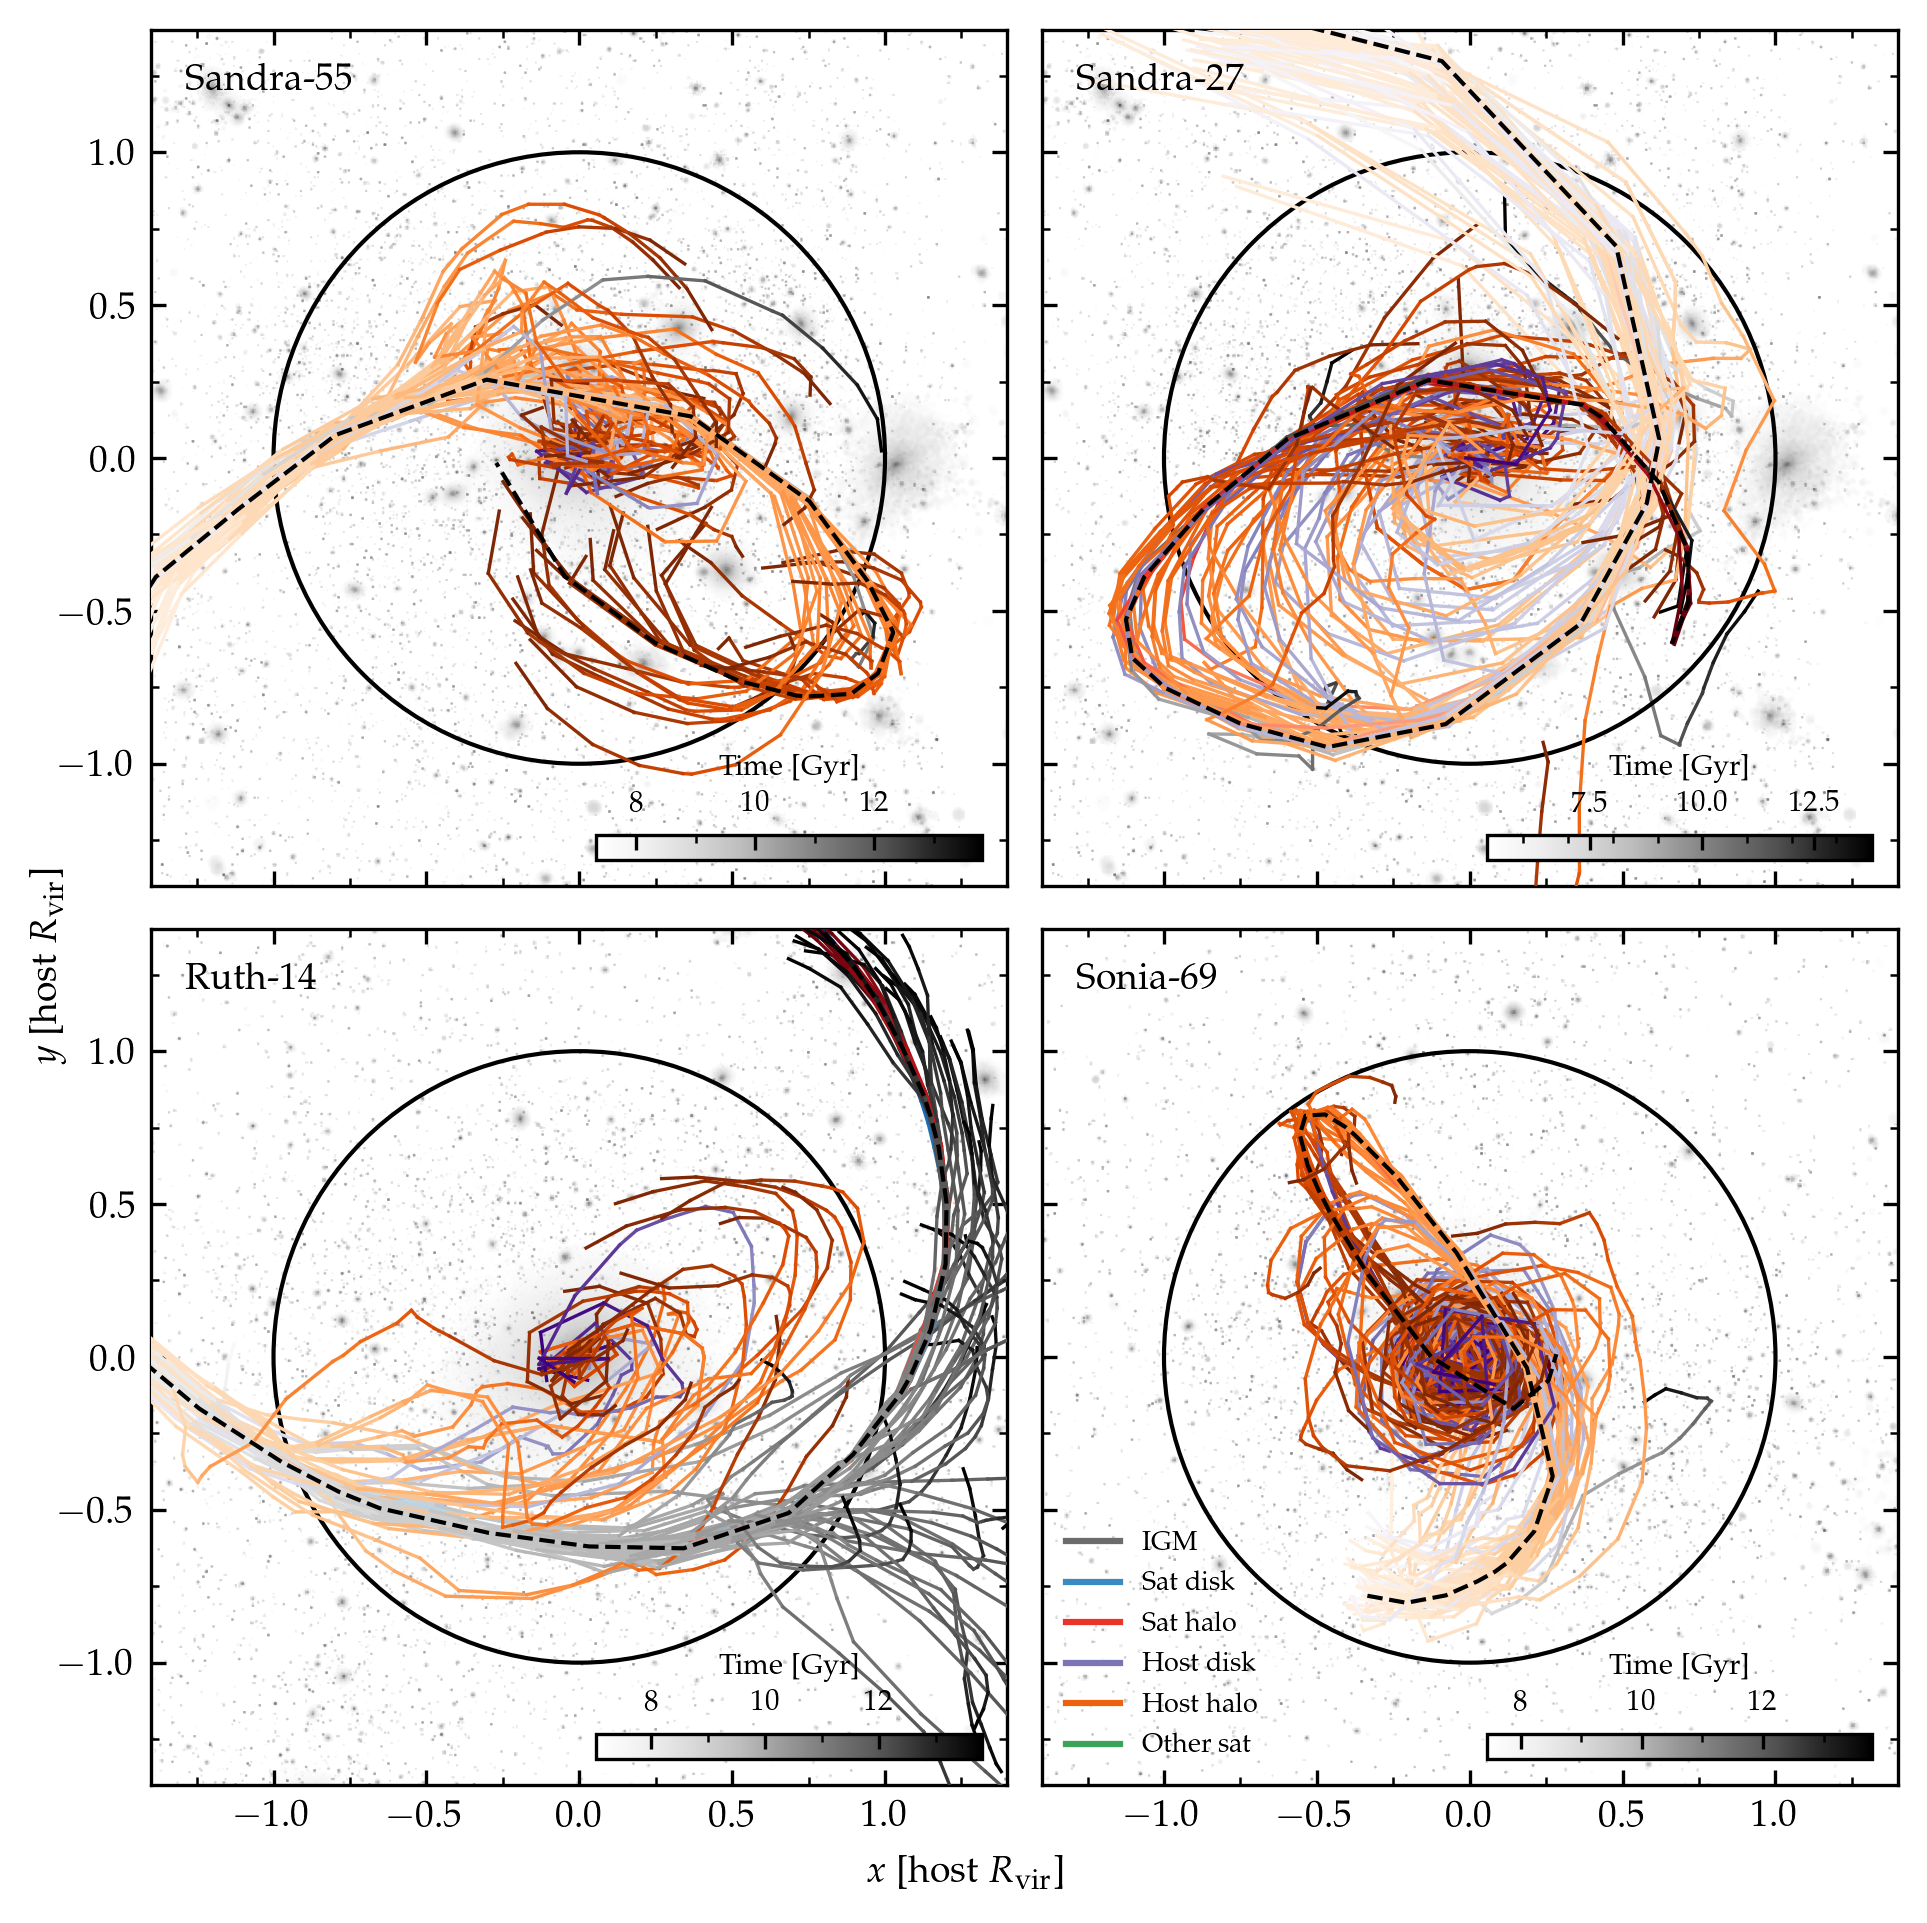

In [16]:
R = 1.4 # in Rvir, the maximum radius to plot 
N = 100 # number of particles to select in subsample

fig = plt.figure(dpi=300, figsize=(6.5,6.5), constrained_layout=False)
gs = mpl.gridspec.GridSpec(2,2, wspace=0.03, hspace=0.05, figure=fig)
gs.update(left=0.08, bottom=0.08, right=0.98, top=0.98)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1], sharey=ax0)
ax2 = plt.subplot(gs[1,0], sharex=ax0)
ax3 = plt.subplot(gs[1,1], sharey=ax2, sharex=ax1)
axes = np.array([ax0,ax1,ax2,ax3])

for ax in axes:
    host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
    ax.add_artist(host_radius)

    
keys = ['h148_55', 'h148_27', 'h229_14', 'h242_69']
names = ['Sandra-55','Sandra-27','Ruth-14','Sonia-69']
for key,name,ax in zip(keys,names,axes):
    path = '../../Data/tracked_particles.hdf5'
    sim = key[:4]
    haloid = key[-2:]
    data = read_tracked_particles(sim,haloid)
    
    pids = np.unique(data.pid)
    np.random.seed(123)
    pids_sub = np.random.choice(pids, size=N)

    cmap_base = mpl.cm.get_cmap('Greys')
    cmaps = np.array([
        mpl.cm.get_cmap('Blues'),
        mpl.cm.get_cmap('Reds'),
        mpl.cm.get_cmap('Purples'),
        mpl.cm.get_cmap('Oranges'),
        cmap_base,
        mpl.cm.get_cmap('Greens')
    ])
    
    for j,pid in enumerate(pids_sub):
        d = data[data.pid==pid]


        tmin, tmax = np.min(data.time), np.max(data.time)

        sat_disk = d.sat_disk.iloc[-1]
        sat_halo = d.sat_halo.iloc[-1]
        host_disk = d.host_disk.iloc[-1]
        host_halo = d.host_halo.iloc[-1]
        IGM = d.IGM.iloc[-1]
        other_sat = d.other_sat.iloc[-1]
        options = np.array(['sat_disk','sat_halo','host_disk','host_halo','IGM','other_sat'])
        bools = np.array([sat_disk, sat_halo, host_disk, host_halo, IGM,other_sat])
        classification = options[bools][0]
        
        i_prev = 0
        for i in range(len(d)-1):
            i += 1
            h1Rvir = list(d.hostRvir)[i_prev]
            x1 = list(d.x_rel_host)[i_prev] / h1Rvir
            y1 = list(d.y_rel_host)[i_prev] / h1Rvir
            z1 = list(d.z_rel_host)[i_prev] / h1Rvir

            h1Rvir = list(d.hostRvir)[i]
            x2 = list(d.x_rel_host)[i] / h1Rvir
            y2 = list(d.y_rel_host)[i] / h1Rvir
            z2 = list(d.z_rel_host)[i] / h1Rvir
            t = list(d.time)[i]

            cmap = cmaps[options == classification][0]
            
            c = cmap((t-tmin)/(tmax-tmin))
            ax.plot([x1,x2],[y1,y2],color=c, linewidth=0.8, zorder=j)

            i_prev = i
            
            
    out = data.groupby(['time'])[['sat_Xc','sat_Yc','host_Xc','host_Yc','hostRvir']].apply(lambda x : x.mean()).reset_index()
    out['X'] = (out.sat_Xc-out.host_Xc)/out.hostRvir
    out['Y'] = (out.sat_Yc-out.host_Yc)/out.hostRvir
    
    ax.plot(out.X, out.Y, linewidth=1, linestyle='--', color='k', zorder=1001)
    
    cbax = ax.inset_axes([0.52,0.03,0.45, 0.03], zorder=1000)
    cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap_base, orientation='horizontal', ticklocation='top',
                                    norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax))
    cb1.set_label('Time [Gyr]', fontsize=7)
    cb1.ax.tick_params(labelsize=7)
    cb1.ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

    ax.annotate(name, (0.04, 0.96), xycoords='axes fraction', va='top', zorder=1000)
    #ax.annotate(r'$N_{\rm tot} =$' + fr' ${len(pids)}$'+'\n'+r'$N_{\rm sub} =$' + fr' ${N}$', (0.96, 0.96), xycoords='axes fraction', va='top', ha='right')
    ax.set_xlim(-R,R)
    ax.set_ylim(-R,R)
    ax.set_aspect('equal')
    ax.tick_params(top=True,right=True,direction='in',which='both')
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

ax0.tick_params(labelbottom=False)
ax3.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False,labelleft=False)

fig.text(0.5, 0.03, r'$x$ [host $R_{\rm vir}$]', ha='center')
fig.text(0.02, 0.5, r'$y$ [host $R_{\rm vir}$]', va='center', rotation='vertical')

ax3.plot([-5,-5],[-5,-4],color=cmaps[4](0.65), label='IGM')
ax3.plot([-5,-5],[-5,-4],color=cmaps[0](0.65), label='Sat disk')
ax3.plot([-5,-5],[-5,-4],color=cmaps[1](0.65), label='Sat halo')
ax3.plot([-5,-5],[-5,-4],color=cmaps[2](0.65), label='Host disk')
ax3.plot([-5,-5],[-5,-4],color=cmaps[3](0.65), label='Host halo')
ax3.plot([-5,-5],[-5,-4],color=cmaps[5](0.65), label='Other sat')

ax3.legend(loc='lower left', fontsize=6.5, frameon=False).set_zorder(2000)

alpha = 0.65
vmin, vmax = 1e4,1e8
with open('../../Data/h148_z0_dm_image.pickle','rb') as f:
    h148_img = pickle.load(f)    
ax0.imshow(h148_img, extent=[-1.4,1.4,-1.4,1.4], norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys', zorder=-1000, alpha=alpha, origin='lower')
ax1.imshow(h148_img, extent=[-1.4,1.4,-1.4,1.4], norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys', zorder=-1000, alpha=alpha, origin='lower')

with open('../../Data/h229_z0_dm_image.pickle','rb') as f:
    h229_img = pickle.load(f)    
ax2.imshow(h229_img, extent=[-1.4,1.4,-1.4,1.4], norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys', zorder=-1000, alpha=alpha, origin='lower')

with open('../../Data/h242_z0_dm_image.pickle','rb') as f:
    h242_img = pickle.load(f)    
ax3.imshow(h242_img, extent=[-1.4,1.4,-1.4,1.4], norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Greys', zorder=-1000, alpha=alpha, origin='lower')


plt.savefig(f'plots/orbits/orbits_overview.pdf')

plt.show()

## Gas fractions in different states over time. <a class="anchor" id="fractions"></a>

Here, we plot what fractions of the total gas mass tracked is in different states over time. This is useful for seeing how gas-loss occurs in the satellites, and where that gas goes. We examine the following categories: 

- Satellite disk
- Satellite halo
- Host halo
- Host disk 
- In another satellite
- Intergalactic Medium (IGM), i.e. outside host and satellite

To do these classifications, we will use the properties `in_sat`, `in_host`, `in_other_sat`, and `in_IGM` first. These are determined via AHF halo ownership (which does its calculations based on whether the gas particle is gravitationally bound to a given halo). Then, we will use thermodynamic cuts to separate between disk and halo. 

The actual classifications are done in the `read_tracked_particles()` function. 

In [236]:
sim, haloid = 'h148', 13
data = read_tracked_particles(sim,haloid,verbose=False)

data.groupby(['time'])[['mass','sat_disk','sat_halo','host_disk','host_halo','other_sat','IGM']]

In [239]:
# convenience function that plots a single panel of the fractions plots, so we can scale up to multiple panels easily
def fill_fractions_ax(key, ax, label=False, show_y_ticks=False):
    sim = str(key[:4])
    haloid = int(key[5:])
    print(sim,haloid)
    
    # read in tracked particles
    data = read_tracked_particles(sim,haloid,verbose=False)

    times = np.unique(data.time)
    frac_satdisk,frac_sathalo,frac_hostdisk,frac_hosthalo,frac_othersat,frac_IGM = np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])

    for t in times:
        d = data[np.abs(data.time-t) < 0.01]
        
        mass_div = np.sum(d.mass)
        
        frac_satdisk = np.append(frac_satdisk,np.sum(d.mass[d.sat_disk])/mass_div)
        frac_sathalo = np.append(frac_sathalo,np.sum(d.mass[d.sat_halo])/mass_div)
        frac_hostdisk = np.append(frac_hostdisk,np.sum(d.mass[d.host_disk])/mass_div)
        frac_hosthalo = np.append(frac_hosthalo,np.sum(d.mass[d.host_halo])/mass_div)
        frac_othersat = np.append(frac_othersat,np.sum(d.mass[d.other_sat])/mass_div)
        frac_IGM = np.append(frac_IGM,np.sum(d.mass[d.IGM])/mass_div)

    timescales = read_timescales()
    timescales = timescales[(timescales.sim==key[:4])&(timescales.haloid==int(key[5:]))]
    tinfall = age - timescales.tinfall.tolist()[0]
    tquench = age - timescales.tquench.tolist()[0]

    lw = 0.6
    alpha = 0.3
    fontsize = 8
    colors = ['mediumblue', 'tab:red', 'darkorchid', 'darkorange', 'g', 'k', 'lightblue']
    
    ax.fill_between(times, 0, frac_satdisk,fc=colors[0], alpha=alpha)
    ax.plot(times, frac_satdisk, color=colors[0], linewidth=lw, zorder=6)

    ax.fill_between(times, frac_satdisk, 
                    frac_satdisk+frac_sathalo, fc=colors[1], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo, color=colors[1], linewidth=lw, zorder=5)

    ax.fill_between(times, frac_satdisk+frac_sathalo, 
                    frac_satdisk+frac_sathalo+frac_hostdisk, fc=colors[2], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk, color=colors[2], linewidth=lw, zorder=4)

    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk, 
                    frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, fc=colors[3], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, color=colors[3], linewidth=lw, zorder=3)

    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo,
                    frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat, fc=colors[4], alpha=alpha)
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat, color=colors[4], linewidth=lw, zorder=2)
    
    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat,
                    frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat+frac_IGM, fc=colors[5], alpha=alpha)

    ax.axline((tinfall,0),(tinfall,1),linestyle='--', linewidth=0.5, color='k')
    ax.axline((tquench,0),(tquench,1),linestyle=':', linewidth=0.5, color='k')

    ax.set_xlim(min(times),max(times))
    ax.set_ylim(0,1)

    if label:
        if key=='h242_24':
            ax.annotate('Sat \n Disk',(7.3,0.28),ha='center', va='center', color=colors[0], size=fontsize)
            ax.annotate('Sat \n Halo',(6.7,0.45),ha='center', va='center', color=colors[1], size=fontsize)
            ax.annotate('Host \n Disk',(12.5,0.15),ha='center', va='center', color=colors[2], size=fontsize)
            ax.annotate('Host \n Halo',(9.5,0.55),ha='center', va='center', color=colors[3], size=fontsize)
            ax.annotate('IGM',(6.7,0.87),ha='center', va='center', color=colors[5], size=fontsize)
    if not show_y_ticks:
        ax.tick_params(labelleft=False)

    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax.tick_params(direction='in', which='both', top=True,right=True)

    ax.annotate(key.replace('_','-'), (0.94, 0.92), xycoords='axes fraction', ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.4', fc='w', ec='0.5', alpha=0.9), zorder=100)

h329 33


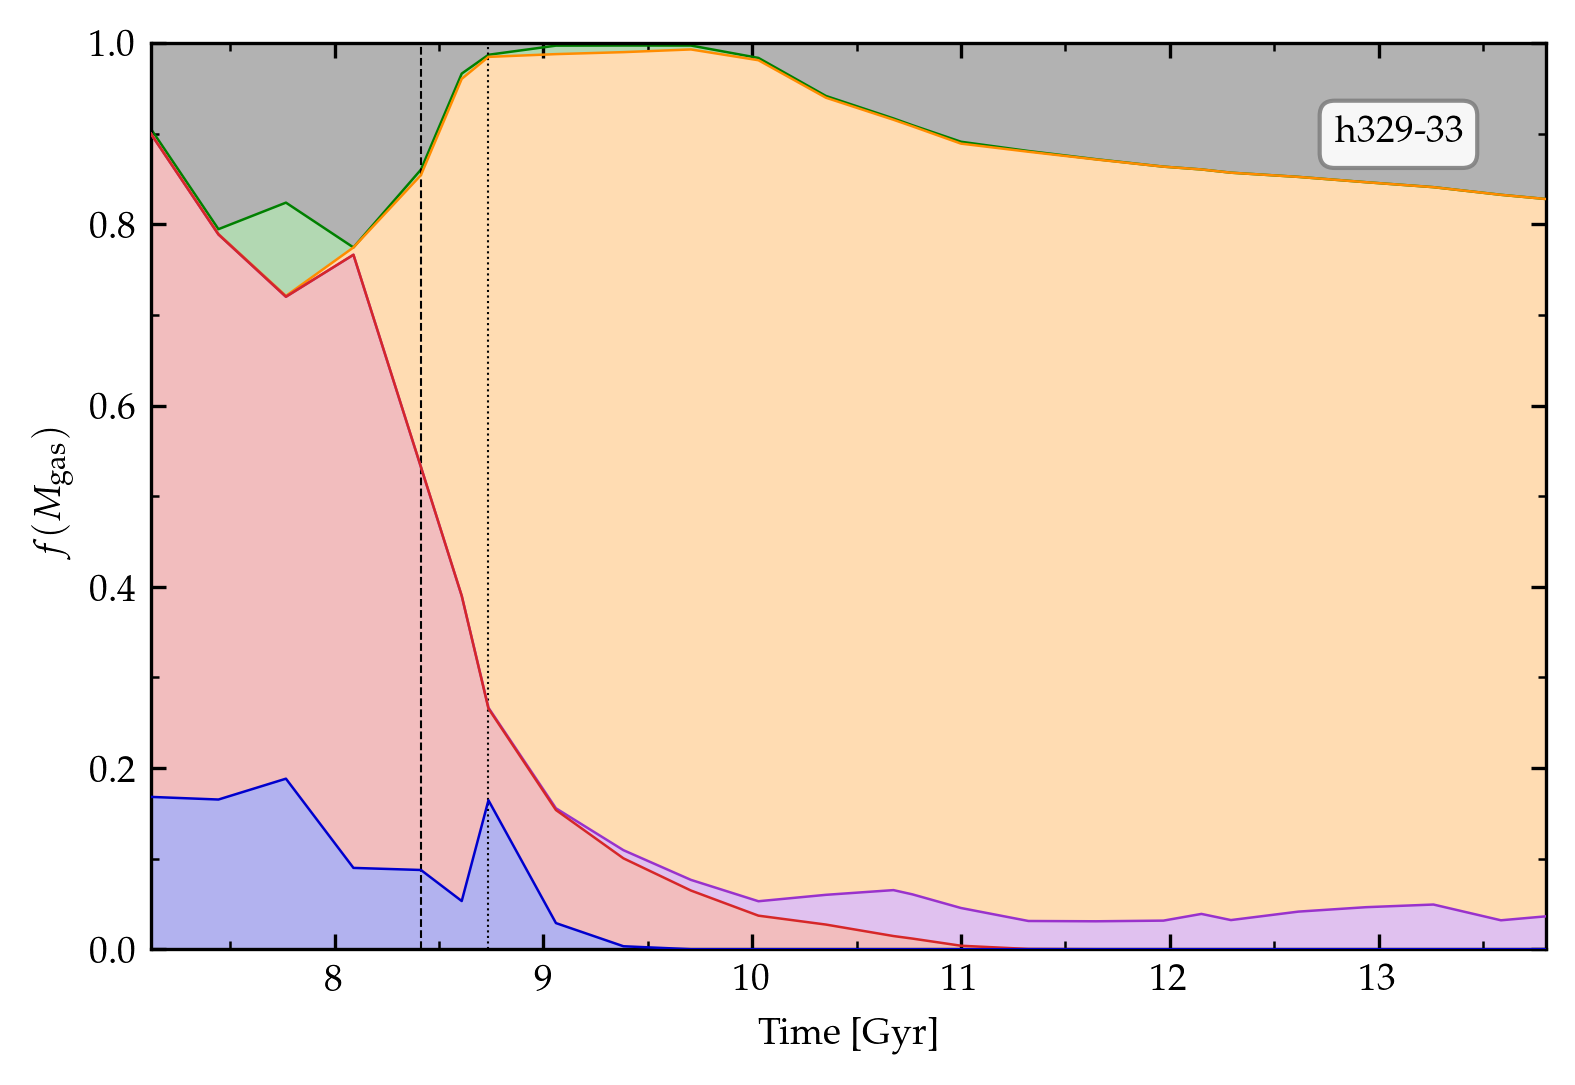

In [240]:
fig, ax = plt.subplots(1,1,dpi=300)
fill_fractions_ax('h329_33',ax,show_y_ticks=True)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$f(M_{\rm gas})$')
plt.show()

## Tracking Stars <a class="anchor" id="stars"></a>

Even though we can now generate plots of gas fractions in different states over time, we need to consider the fact that tracked gas particles can form into stars during the timespan we track them for, and we can lose track of them because of this. 
To remedy this issue, I have written code in `particletracking_stars.py` that uses the `igasorder` property of star particles (which is the `iord` of the gas particle the star formed from) to track the stars formed from gas particles. 

In [241]:
stars = pd.read_hdf('../../Data/tracked_stars.hdf5', key='h148_68')
particles = read_tracked_particles('h148',68)
stars = stars[stars.tform > np.min(particles.time)]

First, we need to test whether we conserve mass in our tracking (roughly). 

We should expect some loss, but not a lot. This is because star particles can form from the gas particles that we are tracking, and some fraction of the mass of those SSPs can be lost quickly due to SNe from dying O/B stars. In our simulation, this mass is transfered to the nearest gas particle—which may or may not be one that we're tracking. If it is, then we achieve perfect mass conservation in our tracking. If it isn't, we lose track of some mass. 

In [242]:
M_gas_start = np.sum(particles[particles.time==np.min(np.unique(particles.time))].mass)
M_gas_end = np.sum(particles[particles.time==np.max(np.unique(particles.time))].mass)
M_star_end = np.sum(stars[stars.time==np.max(np.unique(stars.time))].massform)
print(f'When tracking started, we had {M_gas_start:.2e} Msun worth of gas particles')
print(f'When tracking ended, we had {M_gas_end:.2e} Msun worth of gas particles')
print(f'When tracking ended, we have {M_star_end:.2e} Msun worth stars that formed from tracked gas particles')
print(f'Total loss (absolute): {M_gas_start - M_gas_end - M_star_end:.2e} Msun')
print(f'Total loss (relative): {(M_gas_start - M_gas_end - M_star_end)/M_gas_start:.2f}%')

When tracking started, we had 3.59e+08 Msun worth of gas particles
When tracking ended, we had 3.04e+08 Msun worth of gas particles
When tracking ended, we have 6.74e+07 Msun worth stars that formed from tracked gas particles
Total loss (absolute): -1.15e+07 Msun
Total loss (relative): -0.03%


Something is weird, because we're actually gaining material in our tracking now. Not a lot, but a little for sure. 

For now, we won't worry about that.

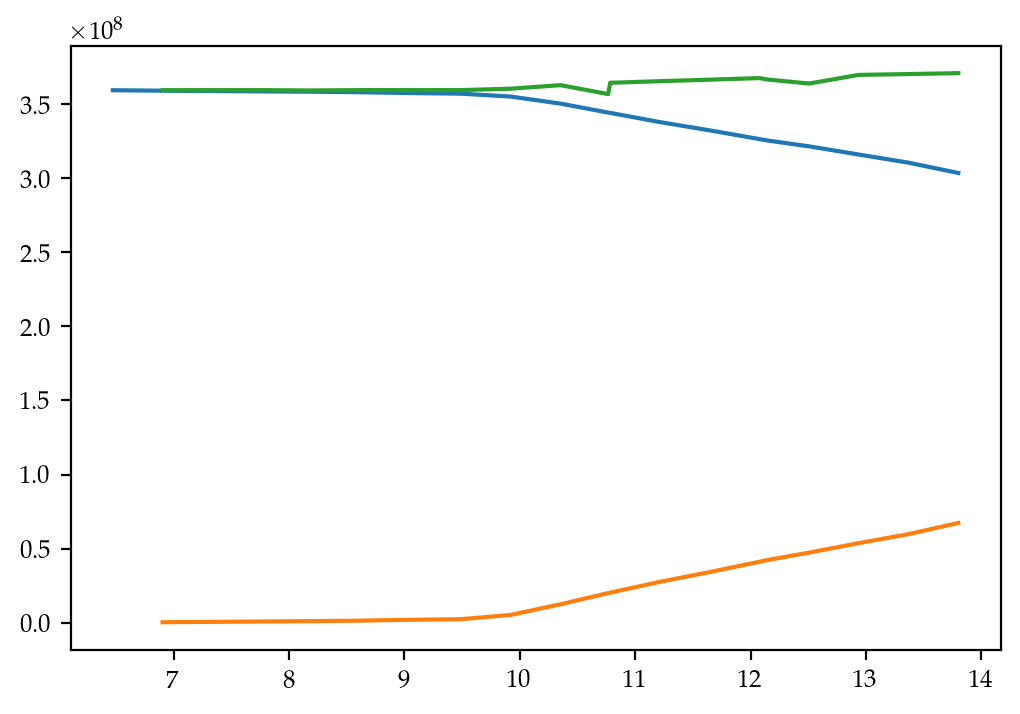

In [243]:
particles_groupby = particles.groupby(['time']).mass.sum().reset_index()
stars_groupby = stars.groupby(['time']).massform.sum().reset_index()

plt.figure(dpi=200)
plt.plot(particles_groupby.time, particles_groupby.mass)
plt.plot(stars_groupby.time, stars_groupby.massform)
merged = pd.merge_asof(particles_groupby, stars_groupby, on='time')
plt.plot(merged.time, merged.mass + merged.massform)
plt.show()

In [244]:
keys = ['h329_33','h148_278','h229_27','h242_41','h148_13','h229_23','h229_55','h148_283','h148_45','h242_24','h229_22','h148_68','h148_37','h242_80','h229_20','h148_28']
print(f'Total loss (relative):')

for key in keys:
    stars = pd.read_hdf('../../Data/tracked_stars.hdf5', key=key)
    particles = read_tracked_particles(key[:4],int(key[5:]))
    stars = stars[stars.tform > np.min(particles.time)]
    M_gas_start = np.sum(particles[particles.time==np.min(np.unique(particles.time))].mass)
    M_gas_end = np.sum(particles[particles.time==np.max(np.unique(particles.time))].mass)
    M_star_end = np.sum(stars[stars.time==np.max(np.unique(stars.time))].massform)
    print(f'{key}: {(M_gas_start - M_gas_end - M_star_end)/M_gas_start*100:.2f}%')

Total loss (relative):
h329_33: -6.91%
h148_278: -7.77%
h229_27: -1.82%
h242_41: -0.24%
h148_13: -5.18%
h229_23: -0.62%
h229_55: -1.87%
h148_283: -5.30%
h148_45: -5.13%
h242_24: -1.70%
h229_22: -5.62%
h148_68: -3.20%
h148_37: -1.66%
h242_80: -0.89%
h229_20: -0.31%
h148_28: -4.55%


Next, we want to remove star particles that didn't form in the satellite, since we don't really care about these.

In [224]:
def determine_if_formed_in_sat(s,p):
    p = p[p.pid==s.igasorder]
    p = p.iloc[np.where(p.time < s.tform)[0]].sort_values('time').iloc[-1]
    s['formedInSat'] = bool(p.in_sat)
    return s
    
from tqdm import tqdm
tqdm.pandas()
stars = stars.progress_apply(determine_if_formed_in_sat, p=particles, axis=1)
stars['formedInSat'] = np.array(np.array(stars.formedInSat,dtype=int),dtype=bool)

100%|██████████| 78879/78879 [03:10<00:00, 414.03it/s]


In [225]:
print(f'{len(stars[stars.formedInSat])/len(stars):.3f}% of stars formed in the satellite')
print('Removing those that did not from stars dataframe...')
stars = stars[stars.formedInSat]
stars

0.094% of stars formed in the satellite
Removing those that did not from stars dataframe...


time      tform     massform          pid  igasorder  formedInSat
151    6.905111   6.478324  5748.547811  118294107.0  2409726.0         True
152    6.905111   6.495159  5702.678865  118356448.0  4060369.0         True
153    6.905111   6.501893  5771.334409  118380133.0  4060345.0         True
154    6.905111   6.511994  5741.418283  118420334.0  2409610.0         True
155    6.905111   6.517886  5724.851943  118442697.0  2408809.0         True
...         ...        ...          ...          ...        ...          ...
7851  13.800797  12.197217  5340.783550  136364526.0  4043981.0         True
7855  13.800797  12.198058  5340.974817  136366596.0  2419073.0         True
9122  13.800797  12.662708  5461.132812  137288638.0  4075313.0         True
9343  13.800797  12.738466  5486.066083  137446395.0  2411276.0         True
9354  13.800797  12.740150  5486.605773  137449833.0  2411717.0         True

[7445 rows x 6 columns]

## Gas fractions in different states over time, including stars <a class="anchor" id="fractions-stars"></a>
 
Now we can include stars in our fractions plots.

In [247]:
def fill_fractions_ax(key, ax, label=False, show_y_ticks=False):
    sim = str(key[:4])
    haloid = int(key[5:])
    print(sim,haloid)
    data = read_tracked_particles(sim,haloid,verbose=False)
    stars = pd.read_hdf('../../Data/tracked_stars.hdf5',key=key)
    stars = stars[stars.tform > np.min(data.time)]
    stars = stars.progress_apply(determine_if_formed_in_sat, p=data, axis=1)
    stars['formedInSat'] = np.array(np.array(stars.formedInSat,dtype=int),dtype=bool)
    print(f'{len(stars[stars.formedInSat])/len(stars):.3f}% of stars formed in the satellite')
    stars = stars[stars.formedInSat]
    
    times = np.unique(data.time)
    frac_formedStars,frac_satdisk,frac_sathalo,frac_hostdisk,frac_hosthalo,frac_othersat,frac_IGM = np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])

    for t in times:
        d = data[np.abs(data.time-t) < 0.01]
        s = stars[np.abs(stars.time-t) < 0.01]
        
        mass_div = np.sum(d.mass) + np.sum(s.massform)
        
        frac_formedStars = np.append(frac_formedStars,np.sum(s.massform)/mass_div)
        frac_satdisk = np.append(frac_satdisk,np.sum(d.mass[d.sat_disk])/mass_div)
        frac_sathalo = np.append(frac_sathalo,np.sum(d.mass[d.sat_halo])/mass_div)
        frac_hostdisk = np.append(frac_hostdisk,np.sum(d.mass[d.host_disk])/mass_div)
        frac_hosthalo = np.append(frac_hosthalo,np.sum(d.mass[d.host_halo])/mass_div)
        frac_othersat = np.append(frac_othersat,np.sum(d.mass[d.other_sat])/mass_div)
        frac_IGM = np.append(frac_IGM,np.sum(d.mass[d.IGM])/mass_div)

    timescales = read_timescales()
    timescales = timescales[(timescales.sim==key[:4])&(timescales.haloid==int(key[5:]))]
    tinfall = age - timescales.tinfall.tolist()[0]
    tquench = age - timescales.tquench.tolist()[0]

    lw = 0.6
    alpha = 0.3
    fontsize = 8
    colors = ['mediumblue', 'tab:red', 'darkorchid', 'darkorange', 'g', 'k', 'lightblue']

    ax.fill_between(times, 0, frac_formedStars, fc=colors[6], alpha=alpha)
    ax.plot(times, frac_formedStars, color=colors[6], linewidth=lw, zorder=7)
    
    ax.fill_between(times, frac_formedStars, frac_formedStars + frac_satdisk,fc=colors[0], alpha=alpha)
    ax.plot(times, frac_formedStars + frac_satdisk, color=colors[0], linewidth=lw, zorder=6)

    ax.fill_between(times, frac_formedStars + frac_satdisk, 
                    frac_formedStars + frac_satdisk+frac_sathalo, fc=colors[1], alpha=alpha)
    ax.plot(times, frac_formedStars + frac_satdisk+frac_sathalo, color=colors[1], linewidth=lw, zorder=5)

    ax.fill_between(times, frac_formedStars + frac_satdisk+frac_sathalo, 
                    frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk, fc=colors[2], alpha=alpha)
    ax.plot(times, frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk, color=colors[2], linewidth=lw, zorder=4)

    ax.fill_between(times, frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk, 
                    frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, fc=colors[3], alpha=alpha)
    ax.plot(times, frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, color=colors[3], linewidth=lw, zorder=3)

    ax.fill_between(times, frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo,
                    frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat, fc=colors[4], alpha=alpha)
    ax.plot(times, frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat, color=colors[4], linewidth=lw, zorder=2)
    
    ax.fill_between(times, frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat,
                    frac_formedStars + frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat+frac_IGM, fc=colors[5], alpha=alpha)
#     ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_IGM, color=colors[5], linewidth=lw, zorder=2)

    ax.axline((tinfall,0),(tinfall,1),linestyle='--', linewidth=0.5, color='k')
    ax.axline((tquench,0),(tquench,1),linestyle=':', linewidth=0.5, color='k')

    ax.set_xlim(min(times),max(times))
    ax.set_ylim(0,1)

    if label:
        if key=='h242_24':
            ax.annotate('Sat \n Disk',(7.3,0.28),ha='center', va='center', color=colors[0], size=fontsize)
            ax.annotate('Sat \n Halo',(6.7,0.45),ha='center', va='center', color=colors[1], size=fontsize)
            ax.annotate('Host \n Disk',(12.5,0.15),ha='center', va='center', color=colors[2], size=fontsize)
            ax.annotate('Host \n Halo',(9.5,0.55),ha='center', va='center', color=colors[3], size=fontsize)
            ax.annotate('IGM',(6.7,0.87),ha='center', va='center', color=colors[5], size=fontsize)
    if not show_y_ticks:
        ax.tick_params(labelleft=False)

    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax.tick_params(direction='in', which='both', top=True,right=True)

    ax.annotate(key.replace('_','-'), (0.94, 0.92), xycoords='axes fraction', ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.4', fc='w', ec='0.5', alpha=0.9), zorder=100)

h329 33


100%|██████████| 68303/68303 [02:34<00:00, 441.20it/s]


0.012% of stars formed in the satellite


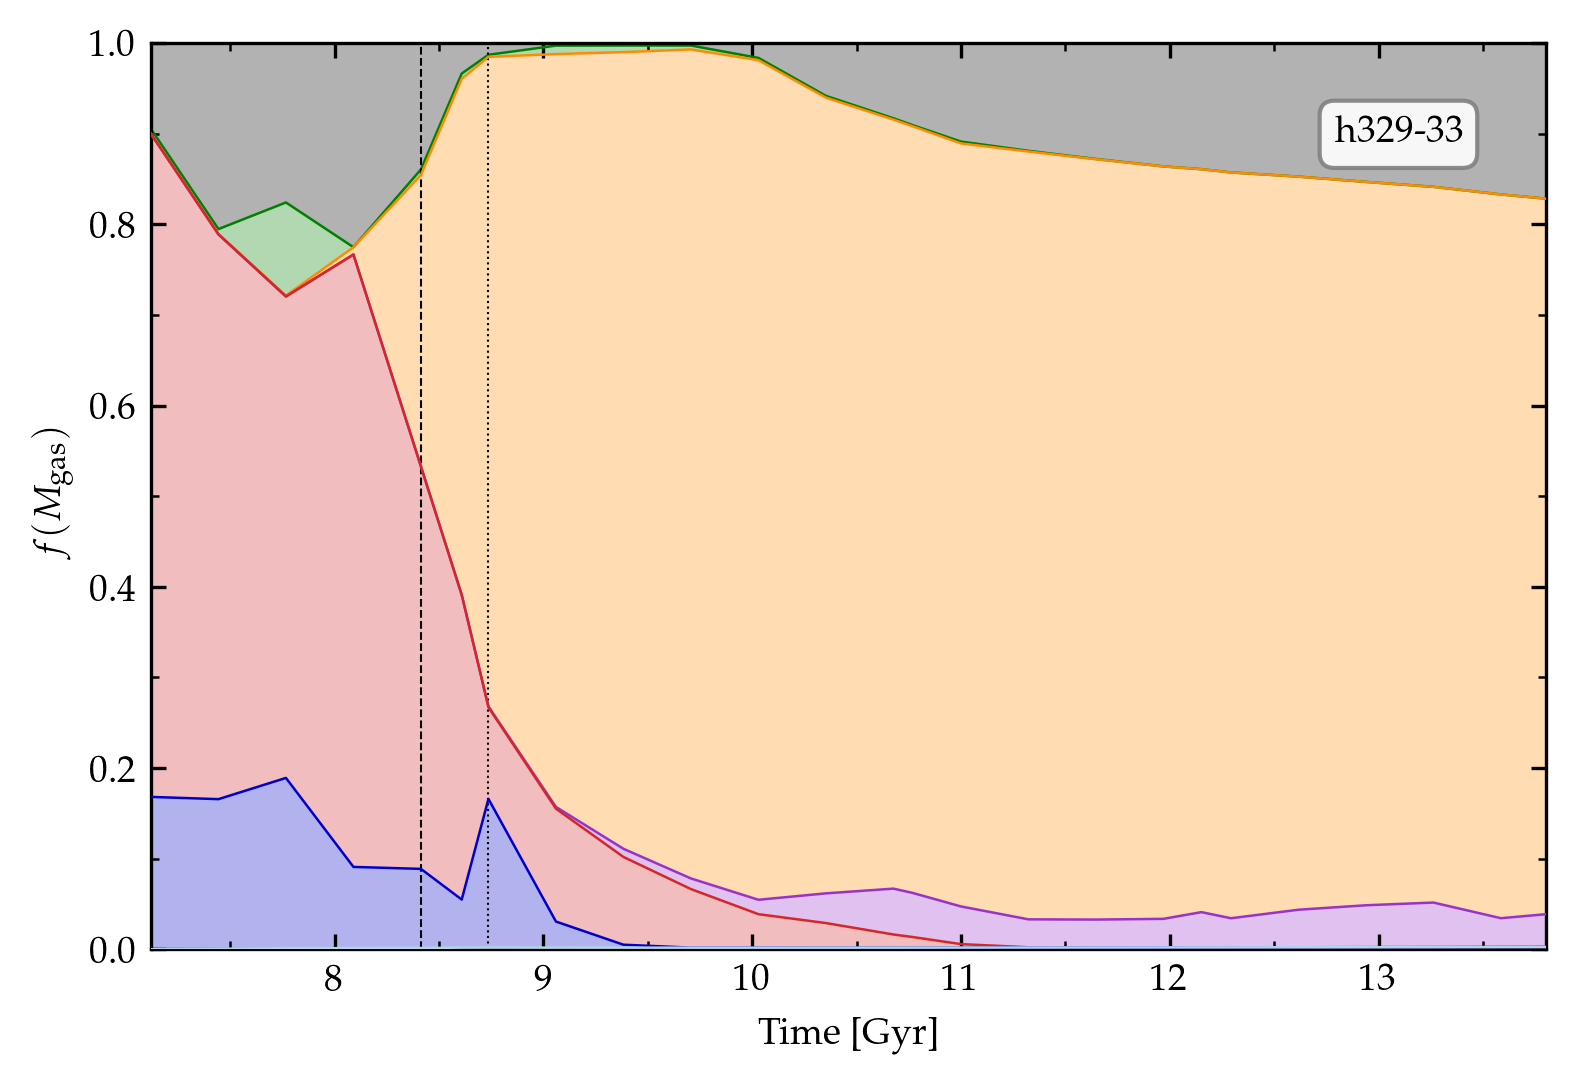

In [248]:
fig, ax = plt.subplots(1,1,dpi=300)
fill_fractions_ax('h329_33',ax,show_y_ticks=True)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$f(M_{\rm gas})$')
plt.show()

The tiny light blue sliver at the bottom is the mass fraction of stars that formed in the satellite. Not much!

h242 24
h148 13
h148 28
h148 37
h148 68
h229 20
h229 22
h242 80


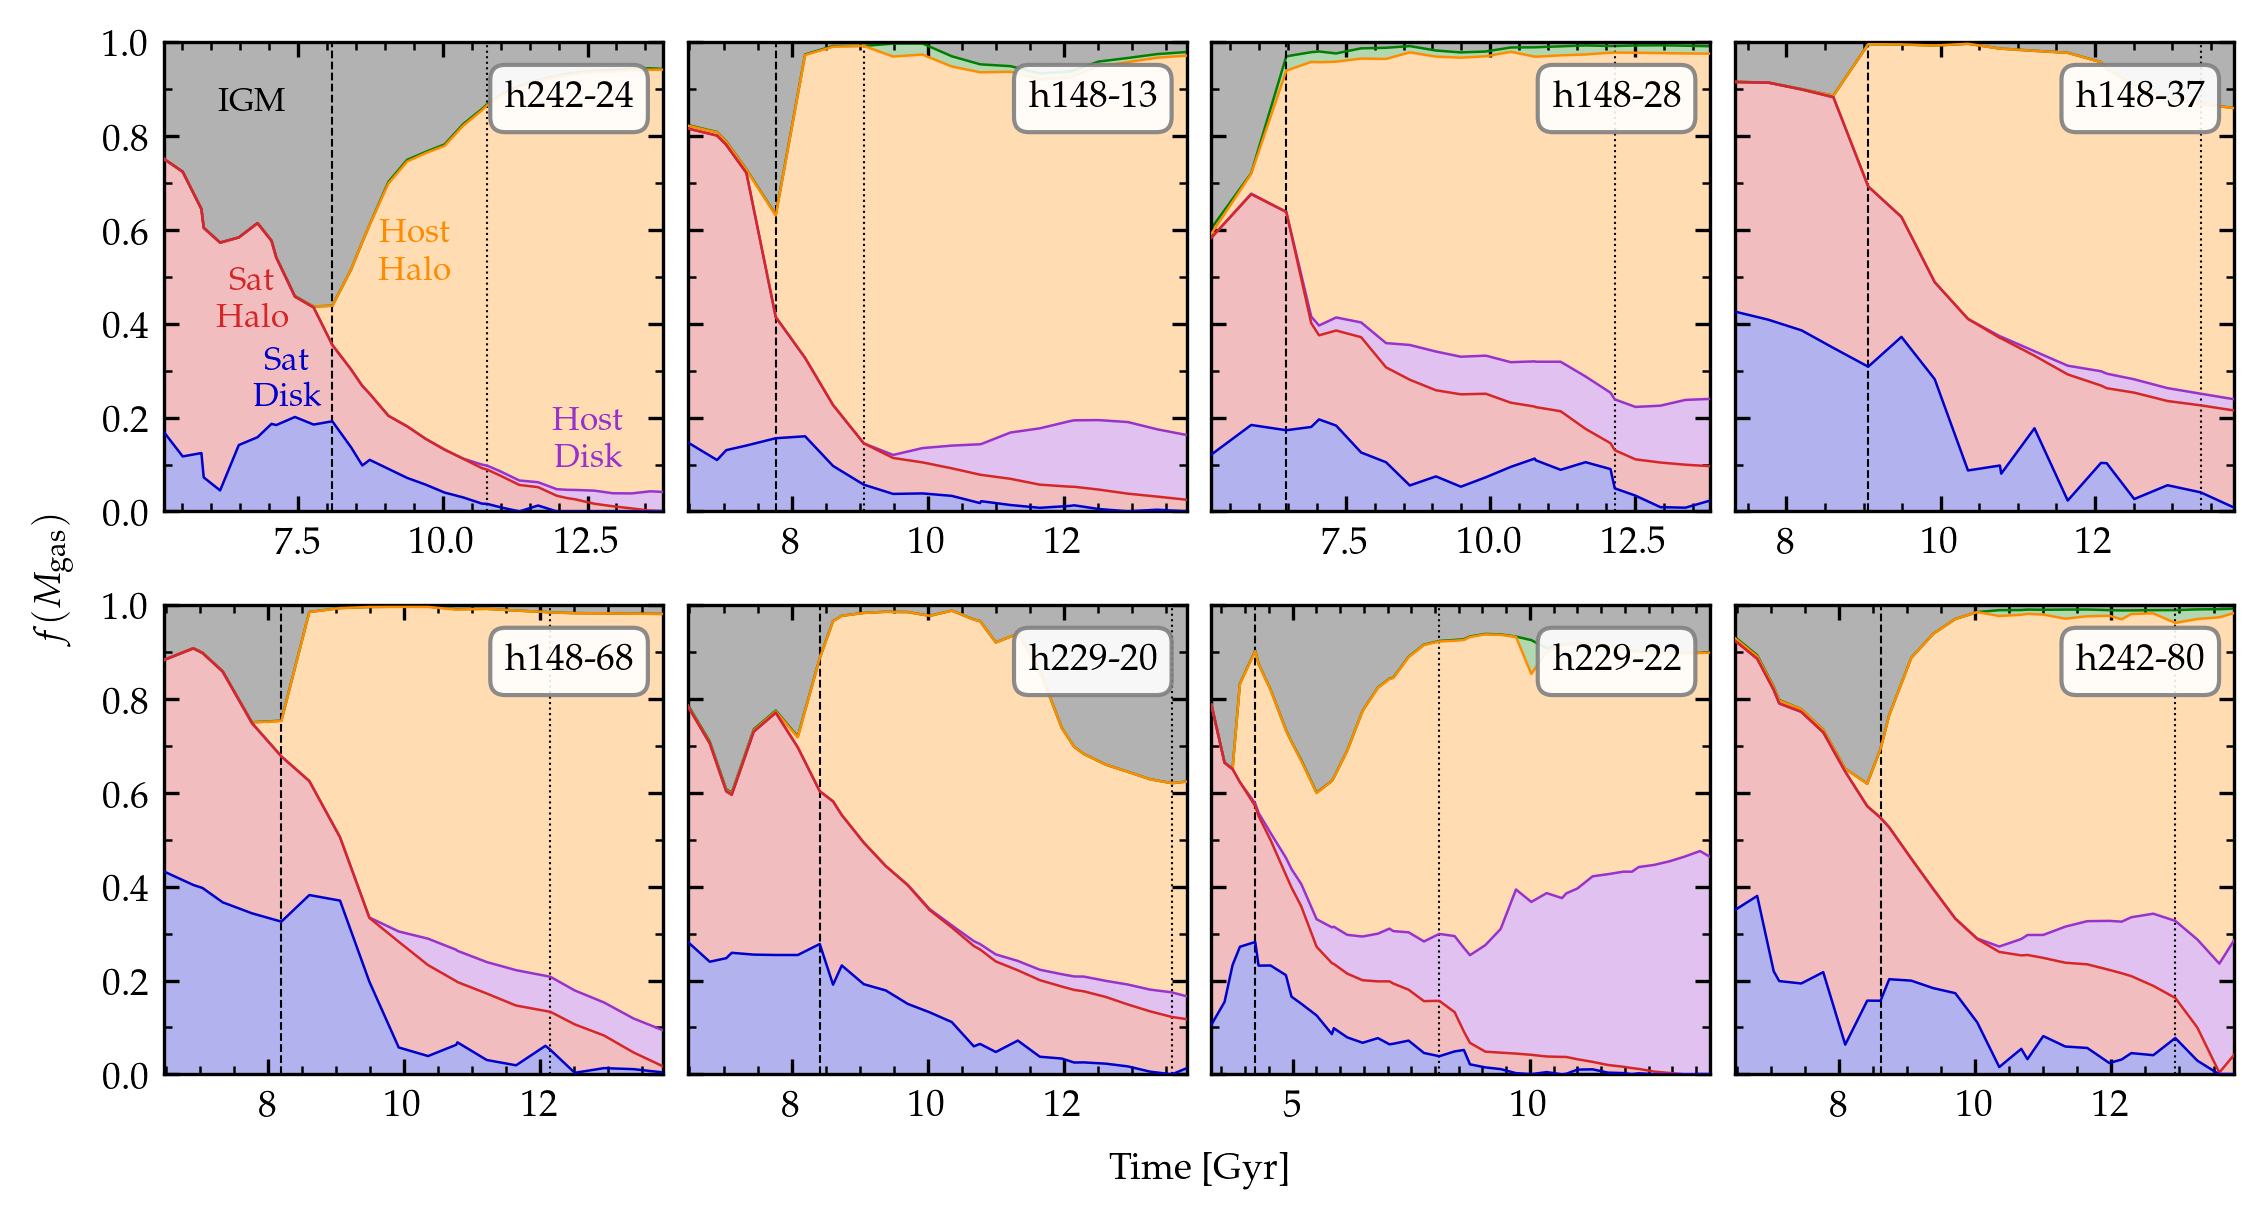

In [15]:
keys = ['h242_24', 'h148_13', 'h148_28', 'h148_37', 'h148_68', 'h229_20', 'h229_22', 'h242_80']

fig = plt.figure(figsize=(7.5, 4), dpi=300)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=4, figure=fig)
gs.update(wspace=0.05, top=0.98, right=0.99, left=0.07, bottom=0.12)

ax0,ax1,ax2,ax3 = plt.subplot(gs[0,0]),plt.subplot(gs[0,1]),plt.subplot(gs[0,2]),plt.subplot(gs[0,3])
ax4,ax5,ax6,ax7 = plt.subplot(gs[1,0]),plt.subplot(gs[1,1]),plt.subplot(gs[1,2]),plt.subplot(gs[1,3])

fill_fractions_ax(keys[0],ax0, label=True, show_y_ticks=True)
fill_fractions_ax(keys[1],ax1)
fill_fractions_ax(keys[2],ax2)
fill_fractions_ax(keys[3],ax3)
fill_fractions_ax(keys[4],ax4, show_y_ticks=True)
fill_fractions_ax(keys[5],ax5)
fill_fractions_ax(keys[6],ax6)
fill_fractions_ax(keys[7],ax7)

fig.text(0.53, 0.04, 'Time [Gyr]', ha='center', va='center')
fig.text(0.02, 0.53, r'$f(M_{\rm gas})$', ha='center', va='center', rotation='vertical')

#plt.savefig(f'plots/fractions/fractions.pdf')
plt.show()

In [250]:
path = '../../Data/tracked_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = [k[1:] for k in hdf.keys()]
    print('Available keys:', *keys)

timescales = read_timescales()
taus = np.array([])
for key in keys:
    sim = key[:4]
    haloid = int(key[5:])
    ts = timescales[(timescales.sim==sim)&(timescales.haloid==haloid)]
    taus = np.append(taus, ts.tinfall.iloc[0] - ts.tquench.iloc[0])
    
keys = np.array(keys)
keys = keys[~np.isnan(taus)]
taus = taus[~np.isnan(taus)]
print('Keys, sorted by quenching timecales:', *np.array(keys)[np.argsort(taus)])

Available keys: h148_13 h148_14 h148_278 h148_28 h148_283 h148_3 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_12 h242_24 h242_41 h242_80 h329_11 h329_137 h329_33
Keys, sorted by quenching timecales: h148_80 h148_329 h329_137 h329_33 h148_278 h229_27 h242_41 h148_13 h229_23 h229_55 h148_283 h148_45 h242_24 h229_22 h148_68 h148_37 h242_80 h229_20 h148_28


We plot the fractions for 16 satellites, sorted by quenching timescale, in the `scripts/census_plots.py`, which is Figure 2 in my current draft paper.

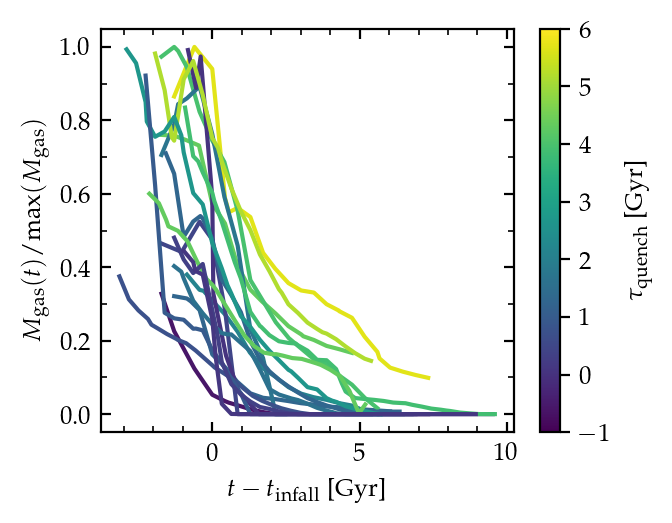

In [29]:
keys = ['h148_13','h148_28','h148_37','h148_45','h148_68','h148_80','h148_283',
        'h148_278','h148_329','h229_20','h229_22','h229_23','h229_27','h229_55',
        'h242_24','h242_41','h242_80','h329_33','h329_137']

fig, ax = plt.subplots(1,1,figsize=(3.25,2.5))

from copy import copy
cmap = copy(mpl.cm.get_cmap('viridis'))

timescales = read_timescales()


for key in keys:
    sim = str(key[:4])
    haloid = int(key[5:])
    data = read_tracked_particles(sim,haloid,verbose=False) 
    data['mass_insat'] = data.mass * np.array(data.sat_disk | data.sat_halo, dtype=int)
    data = data.groupby(['time'])['mass_insat'].sum().reset_index()
    
    ts = timescales[(timescales.sim==sim)&(timescales.haloid==haloid)]
    tinfall = age - ts.tinfall.tolist()[0]
    tquench = age - ts.tquench.tolist()[0]
    
    timesteps = read_timesteps(sim)
    timesteps = timesteps[timesteps.z0haloid == haloid]
    Mgas_peak = np.max(timesteps.mgas)
    
    tau = tquench - tinfall
    vmin, vmax = -1, 6
    
    x = data.time - tinfall
    #y = data.mass_insat / data.mass_insat.tolist()[0]
    y = data.mass_insat / Mgas_peak
    c = cmap((tau-vmin)/(vmax-vmin))
    
    ax.plot(x,y,color=c)
    
    
    
    
ax.set_xlabel(r'$t-t_{\rm infall}$ [Gyr]')
ax.set_ylabel(r'$M_{\rm gas}(t)/{\rm max}(M_{\rm gas})$')

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                    ax=ax, label=r'$\tau_{\rm quench}$ [Gyr]')
cbar.ax.tick_params(direction='out',which='both')

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.show()

If $M_{\rm gas}(t)/{\rm max}(M_{\rm gas})$ is $\ll 1$ for the first datapoint on the plot, then we know that the satellite has experienced some preprocessing.

Check "preprocessed" satellites

Use line style to indicate quenching